In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn import svm
import networkx as nx
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
import numpy as np
import itertools
from imblearn.over_sampling import RandomOverSampler 
import shap
from sklearn.metrics import precision_score

In [2]:
df = pd.read_csv('/Users/harshil.dadlani/Desktop/UW_Courses/2021_Fall/560/Project/Datasets/Extracted_Data/final_extracted_a0f66459.csv')

In [3]:
electrode_col_names = [col for col in df.columns if 'GRID' in col ]

In [4]:
#random_state=1 is best
X = df[electrode_col_names]
Y = df['mvmt']
mapping = {'mv_0':0, 'r_arm_1':1}
Y = Y.map(mapping)
scoring_metrics = ['balanced_accuracy', 'accuracy', 'average_precision']
random_state=1

In [5]:
# Separate out the test-set as hold-out (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, Y,stratify=Y, test_size=0.20,random_state=random_state)

In [6]:
#test_size=len(round(y_test))/2
int(len(y_test)/2)

168

In [7]:
# Define utility functions
def get_scores(X,y,classifier,scoring_metrics):
    cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=random_state)
    pipeline = make_pipeline(classifier)
    scores = cross_validate(pipeline, X, y, scoring=scoring_metrics, cv=cv, n_jobs=-1)
    return {'balanced_accuracy':scores['test_balanced_accuracy'].mean(),
            'accuracy':scores['test_accuracy'].mean()}
            
def get_positively_correlated_features(df, threshold=0.6):
    cols = X_train.corr().unstack()
    cols = cols.sort_values(kind="quicksort",ascending=False)[64:]
    corr_elems = list(cols[cols>threshold].index)
    correlated_features = [list(pair) for pair in corr_elems[1::2]]
    g = nx.Graph()
    ipath = correlated_features
    for p in ipath:
        g.add_edges_from(zip(p, p[1:]))
    correlated_features = []
    for c in nx.connected_components(g):
        correlated_features.append(list(c))
    return correlated_features

In [8]:
# Random guessing
y_train.value_counts()/len(y_train)

1    0.639344
0    0.360656
Name: mvmt, dtype: float64

In [9]:
# Iteration-0, Baseline model
clf = LogisticRegression(C=10,random_state=random_state)
get_scores(X_train,y_train,clf,scoring_metrics=scoring_metrics)


{'balanced_accuracy': 0.49863707165109034, 'accuracy': 0.6376042557741659}

In [10]:
# Iteration-0, Test Set performance
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
acc = accuracy_score(y_test,pred)
bac = balanced_accuracy_score(y_test,pred)
print(f'ACC : {acc}')
print(f'BAC : {bac}')

ACC : 0.6398809523809523
BAC : 0.5


In [11]:
# Utility functions
def tune_rf(X_train, y_train, criteria='accuracy'):
    grid_combo = list(itertools.product(n_estimators, max_features, max_depth,min_samples_split,min_samples_leaf,bootstrap))
    best_res = None
    best_model = None
    max_iter=100
    iter_1=0
    best_metric=0
    criteria = criteria
    for combo in grid_combo:
        clf = RandomForestClassifier(n_estimators=combo[0], max_features=combo[1], max_depth=combo[2],min_samples_split=combo[3],min_samples_leaf=combo[4],bootstrap=combo[5],random_state=random_state)
        res = get_scores(X_train,y_train,clf,scoring_metrics=scoring_metrics)
        if res[criteria]>best_metric:
            best_metric=res[criteria]
            best_res=res
            best_model=combo
        if iter_1==max_iter:
            break
        iter_1+=1
    return best_model, best_res

def perform_dimensionality_reduction(X_train,X_val,threshold=0.7):
    correlated_features = get_positively_correlated_features(X_train,threshold)
    combined_features=[]
    X_train_temp=pd.DataFrame()
    X_val_temp = pd.DataFrame()
    for group in correlated_features:
        combined_features.extend(group)
        if len(group)==2:
            pca = PCA(n_components=1,random_state=random_state)
            pca.fit(X_train[group])
            X_train_temp['_'.join(group)+'_PC1']=pd.Series(pca.transform(X_train[group]).T[0],index=X_train.index)
            X_val_temp['_'.join(group)+'_PC1']=pd.Series(pca.transform(X_val[group]).T[0],index=X_val.index)
        else:
            pca = PCA(n_components=2,random_state=random_state)
            pca.fit(X_train[group])
            X_train_temp['_'.join(group)+'_PC1']=pd.Series(pca.transform(X_train[group]).T[0],index=X_train.index)
            X_train_temp['_'.join(group)+'_PC2']=pd.Series(pca.transform(X_train[group]).T[1],index=X_train.index) 
            
            X_val_temp['_'.join(group)+'_PC1']=pd.Series(pca.transform(X_val[group]).T[0],index=X_val.index)        
            X_val_temp['_'.join(group)+'_PC2']=pd.Series(pca.transform(X_val[group]).T[1],index=X_val.index)
    
    return X_train_temp.join(X_train.drop(combined_features,axis=1)), X_val_temp.join(X_val.drop(combined_features,axis=1))

In [12]:
# Iteration-1, Random Forest tuning

# Number of trees in random forest
n_estimators = [100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10,20,30,40,50,60,70,80,90,100,110,120]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

best_model, best_score=tune_rf(X_train, y_train)


In [13]:
# Iteration-1, Test Set performance
clf=RandomForestClassifier(n_estimators=best_model[0], max_features=best_model[1], max_depth=best_model[2],min_samples_split=best_model[3],min_samples_leaf=best_model[4],bootstrap=best_model[5],random_state=random_state)
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
acc = accuracy_score(y_test,pred)
bac = balanced_accuracy_score(y_test,pred)
print(f'ACC : {acc}')
print(f'BAC : {bac}')

ACC : 0.6875
BAC : 0.6257351527964636


In [14]:
# Iteration-2, Perform Dimensionality reduction and tune Random Forest Classifier

X_train_2, X_test_2 = perform_dimensionality_reduction(X_train, X_test, threshold=0.55)
# Number of trees in random forest
n_estimators = [100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [5,10,15,20,25,30,35,40,45,50,60,70,80,90,100]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

best_model, best_score=tune_rf(X_train_2, y_train)

In [15]:
# Test Set Performance 2
clf=RandomForestClassifier(n_estimators=best_model[0], max_features=best_model[1], max_depth=15,min_samples_split=best_model[3],min_samples_leaf=best_model[4],bootstrap=True,random_state=random_state)
clf.fit(X_train_2,y_train)
pred=clf.predict(X_test_2)
acc = accuracy_score(y_test,pred)
bac = balanced_accuracy_score(y_test,pred)
print(f'ACC : {acc}')
print(f'BAC : {bac}')

ACC : 0.7202380952380952
BAC : 0.692869498366327


In [16]:
# Iteration-3, Perform Dimensionality reduction and run Logistic Regression

X_train_3, X_test_3 = perform_dimensionality_reduction(X_train, X_test, threshold=0.55)
clf = LogisticRegression(C=0.011,random_state=random_state)
get_scores(X_train,y_train,clf,scoring_metrics=scoring_metrics)

{'balanced_accuracy': 0.5, 'accuracy': 0.6393463073852296}

In [95]:
# Iteration-4, Perform Dimensionality reduction and use random oversampler
X_train_4, X_test_4 = perform_dimensionality_reduction(X_train, X_test, threshold=0.55)
y_train_4 = y_train.copy()
ros =RandomOverSampler(random_state=random_state)
ros.fit(X_train_4,y_train_4)
X_train_4,y_train_4 = ros.fit_resample(X_train_4,y_train_4)

In [96]:
y_test_4 = y_test.copy()

In [97]:
best_model, best_score=tune_rf(X_train_4, y_train_4)

In [98]:
# Test Set Performance 4
clf=RandomForestClassifier(n_estimators=best_model[0], max_features=best_model[1], max_depth=best_model[2],min_samples_split=best_model[3],min_samples_leaf=best_model[4],bootstrap=best_model[5],random_state=random_state)
clf.fit(X_train_4,y_train_4)
pred=clf.predict(X_test_4)
acc = accuracy_score(y_test_4,pred)
bac = balanced_accuracy_score(y_test_4,pred)
print(f'ACC : {acc}')
print(f'BAC : {bac}')

ACC : 0.7232142857142857
BAC : 0.7006150297905055


In [52]:
col_names = list(X_train_4.columns)
explainer = shap.TreeExplainer(clf)
correct_pred=y_test.loc[y_test==pred]
r_arm_indices = correct_pred.loc[correct_pred==1].index
n_mvmt_indices = correct_pred.loc[correct_pred==0].index

vals = np.array([0.0]*len(col_names))
for index in list(r_arm_indices):
    choosen_instance = X_test_4.loc[index]
    shap_values = explainer.shap_values(choosen_instance)
    vals+=np.array(list(shap_values[1]))

keys = col_names  
dictionary = dict(zip(keys, vals))


In [53]:
imp_feats = sorted(dictionary.items(), key=lambda x:x[1])

In [54]:
arr = [-45.8222, 40.0876, 38.3409,
-48.5203, 31.3562, 42.0835,
-49.0871, 23.7534, 45.6563,
-50.4878, 12.3137, 51.0193,
-50.8957, 2.55962, 53.7372,
-53.5938, -6.17175, 57.4798,
-53.9306, -16.912, 60.3523,
-54.4095, -25.6799, 62.9156,
-51.1927, 38.2999, 29.0653,
-54.9919, 29.4973, 32.8155,
-54.3527, 20.6217, 34.207,
-56.9256, 10.0969, 39.423,
-60.6707, 0.487121, 44.4919,
-61.0786, -9.26696, 47.2098,
-61.5034, -18.8421, 51.0919,
-60.8101, -28.525, 53.8023,
-54.344, 36.4757, 18.6105,
-57.9673, 25.3429, 20.3415,
-59.4932, 15.6966, 24.2311,
-62.2082, 7.14414, 29.1379,
-64.8352, -2.5734, 33.0351,
-66.3611, -12.2197, 36.9247,
-66.769, -21.9738, 39.6426,
-66.0757, -31.6567, 42.353,
-57.0929, 29.4542, 0.624882,
-57.7104, 22.3883, 7.69024,
-61.4555, 12.7785, 12.7592,
-64.1535, 4.04709, 16.5018,
-67.8817, -5.74167, 20.4065,
-69.4245, -15.2091, 25.4603,
-69.8324, -24.9631, 28.1782,
-68.0549, -34.3958, 32.0452,
-52.4112, 26.3351, -8.40951,
-56.2103, 17.5325, -4.65936,
-61.1986, 9.82382, 0.107904,
-65.0147, 1.2002, 5.02222,
-67.6417, -8.51735, 8.91942,
-70.2687, -18.2349, 12.8166,
-69.5924, -27.7388, 16.6911,
-70.0171, -37.3139, 20.5732,
-46.5607, 22.5713, -22.1081,
-54.9571, 15.9931, -15.1445,
-61.0465, 8.21327, -10.3696,
-65.8048, -2.63288, -6.30269,
-68.4318, -12.3504, -2.40549,
-69.9577, -21.9968, 1.48414,
-70.3825, -31.5719, 5.36622,
-70.7903, -41.326, 8.08412,
-47.4015, 19.2751, -29.9405,
-54.7171, 13.2175, -26.6316,
-62.8498, 3.14385, -22.6965,
-65.4768, -6.5737, -18.7993,
-69.205, -16.3625, -14.8946,
-69.6298, -25.9376, -11.0125,
-70.0545, -35.5127, -7.13043,
-71.5805, -45.1591, -3.2408,
-44.78, 14.0412, -38.6506,
-53.1088, 6.7472, -36.3436,
-61.4376, -0.546801, -34.0366,
-64.0647, -10.2644, -30.1394,
-68.894, -20.1243, -26.2271,
-70.4199, -29.7707, -22.3374,
-66.4401, -39.0609, -18.4856,
-67.9829, -48.5283, -13.4318,
-25.436, -101.35, -12.1776,
-36.9107, -95.5164, -15.5126,
-44.2614, -85.7239, -14.6851,
-51.487, -77.7249, -12.3841,
-55.3382, -70.4984, -9.95123,
-63.7732, -60.9561, -10.2803,
-20.4774, -62.8394, -14.6135,
-28.6318, -56.9715, -19.1354,
-35.597, -52.1975, -24.6744,
-43.7683, -46.1506, -28.0321,
-53.0407, -40.1749, -31.3822,
-63.3025, -36.1552, -27.276,
-33.0038, -42.122, -26.2432,
-44.2316, -39.6052, -31.4427,
-53.2537, -37.2163, -31.8461,
-65.6637, -34.1463, -26.4059,
-12.5245, -3.95891, -30.9587,
-20.9853, -8.91875, -39.7477,
-30.7738, -11.0827, -43.0175,
-42.6022, -15.8107, -42.3159,
-53.6642, -15.986, -38.7477,
-66.8541, -17.5602, -30.1986,
-27.0398, 0.510056, 6.44614,
-32.3197, 1.76514, 7.9016,
-37.8859, 2.74983, 8.87865,
-43.0039, 3.63307, 9.99345,
-48.1466, 4.76746, 11.076,
-53.6054, 5.77725, 12.4715,
-56.9877, 4.42048, 15.8705,
-57.1087, 1.80718, 19.7188]
coords = np.array(arr[:192]).reshape(64,3)

In [55]:
def get_node_strength(old_dict):
    new_dict = {}
    for key in old_dict.keys():
        split_electrodes = key.split("_")
        if len(split_electrodes)>1:
            for electrode in split_electrodes[:-1]:
                new_dict[int(electrode[4:])]=old_dict[key]
        else:
            new_dict[int(key[4:])]=old_dict[key]
    return new_dict
    
op = get_node_strength(dictionary)

In [56]:
res = [item[1] for item in sorted(op.items())]

In [78]:
sort_op = [[k,v] for k, v in sorted(op.items(), key=lambda item: item[1],reverse=True)]

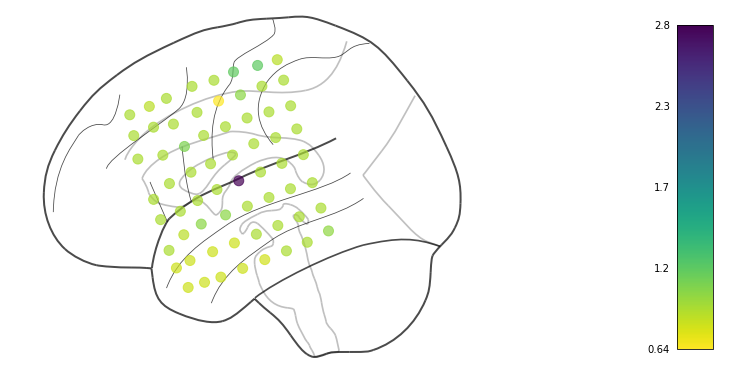

In [94]:
import matplotlib.pyplot as plt
from nilearn import plotting
fig = plt.figure(figsize=(10, 5))

plotting.plot_markers(
    np.log1p(res),
    coords,
    display_mode='l', figure=fig
)

<AxesSubplot:>

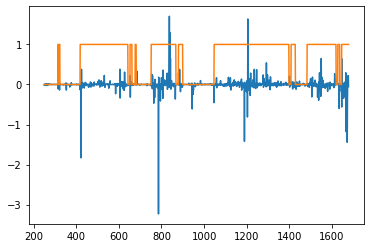

In [59]:
X['GRID37'][250:2000].plot()
Y[250:2000].plot()